<a href="https://colab.research.google.com/github/devanshsingh2004/ImageClassifier/blob/main/Q1_ImageClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Load CIFAR-10 Dataset

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Download CIFAR-10 (small version) dataset
print("Downloading CIFAR-10 dataset...")
cifar10 = fetch_openml('CIFAR_10_small', version=1)

# FIXED: Convert from DataFrame to NumPy array before reshape
X = cifar10.data.to_numpy().reshape(-1, 3, 32, 32).astype(np.uint8)
y = np.array(cifar10.target)

#Select only 3 classes (by number as strings)
selected_classes = ['3', '5', '7']  # cat, dog, horse
mask = np.isin(y, selected_classes)
X = X[mask]
y = y[mask]

print("Number of selected images:", len(X))

# Convert to grayscale and normalize
X_gray = X.mean(axis=1)
X_normalized = X_gray / 255.0

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Use 300 samples per class
X_small, y_small = [], []
for class_label in [0, 1, 2]:
    idx = np.where(y_encoded == class_label)[0][:1500]
    X_small.append(X_normalized[idx])
    y_small.append(y_encoded[idx])

X_small = np.concatenate(X_small)
y_small = np.concatenate(y_small)

# Train-test split (20% test = 180 images)
X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.2, random_state=42)


print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Class labels:", le.classes_)

Number of selected images: 5954
Train shape: (3600, 32, 32)
Test shape: (900, 32, 32)
Class labels: ['3' '5' '7']


## Step 1.2 Neural Network Model (NumPy)

In [2]:
import numpy as np

class ImprovedDeepNet:
    def __init__(self, input_size=1024, output_size=3, dropout_rate=0.3):
        self.dropout_rate = dropout_rate

        # Layer sizes
        hidden_sizes = [512, 512, 256, 128, 64]

        # Initialize parameters
        self.params = {
            'W1': np.random.randn(input_size, hidden_sizes[0]) * np.sqrt(2. / input_size),
            'b1': np.zeros((1, hidden_sizes[0])),
            'W2': np.random.randn(hidden_sizes[0], hidden_sizes[1]) * np.sqrt(2. / hidden_sizes[0]),
            'b2': np.zeros((1, hidden_sizes[1])),
            'W3': np.random.randn(hidden_sizes[1], hidden_sizes[2]) * np.sqrt(2. / hidden_sizes[1]),
            'b3': np.zeros((1, hidden_sizes[2])),
            'W4': np.random.randn(hidden_sizes[2], hidden_sizes[3]) * np.sqrt(2. / hidden_sizes[2]),
            'b4': np.zeros((1, hidden_sizes[3])),
            'W5': np.random.randn(hidden_sizes[3], hidden_sizes[4]) * np.sqrt(2. / hidden_sizes[3]),
            'b5': np.zeros((1, hidden_sizes[4])),
            'W6': np.random.randn(hidden_sizes[4], output_size) * np.sqrt(2. / hidden_sizes[4]),
            'b6': np.zeros((1, output_size)),
        }

    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        return Z > 0

    def softmax(self, Z):
        exps = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)

    def dropout(self, A, rate):
        mask = (np.random.rand(*A.shape) > rate).astype(np.float32)
        return A * mask / (1.0 - rate), mask

    def forward(self, X, training=True):
        self.cache = {'X': X}
        A = X

        for i in range(1, 6):
            Z = A @ self.params[f'W{i}'] + self.params[f'b{i}']
            A = self.relu(Z)
            if training:
                A, mask = self.dropout(A, self.dropout_rate)
                self.cache[f'mask{i}'] = mask
            self.cache[f'Z{i}'] = Z
            self.cache[f'A{i}'] = A

        # Final layer (no ReLU or dropout)
        Z6 = A @ self.params['W6'] + self.params['b6']
        A6 = self.softmax(Z6)

        self.cache['Z6'] = Z6
        self.cache['A6'] = A6
        return A6

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        y_one_hot = np.zeros_like(y_pred)
        y_one_hot[np.arange(m), y_true] = 1
        loss = -np.sum(y_one_hot * np.log(y_pred + 1e-8)) / m
        return loss

    def backward(self, y_true, learning_rate=0.01):
        m = y_true.shape[0]
        y_pred = self.cache['A6']
        y_one_hot = np.zeros_like(y_pred)
        y_one_hot[np.arange(m), y_true] = 1

        dZ = y_pred - y_one_hot

        # Backprop through each layer
        for i in reversed(range(1, 7)):
            A_prev = self.cache['A' + str(i - 1)] if i > 1 else self.cache['X']
            dW = A_prev.T @ dZ / m
            db = np.sum(dZ, axis=0, keepdims=True) / m

            self.params[f'W{i}'] -= learning_rate * dW
            self.params[f'b{i}'] -= learning_rate * db

            if i > 1:
                dA = dZ @ self.params[f'W{i}'].T
                if f'mask{i-1}' in self.cache:
                    dA *= self.cache[f'mask{i-1}']
                dZ = dA * self.relu_derivative(self.cache[f'Z{i-1}'])


## Step 1.3 – Training Loop with Accuracy and Loss Plot

Epoch 1/600 - Loss: 1.2557, Accuracy: 0.3344
Epoch 5/600 - Loss: 1.1192, Accuracy: 0.3514
Epoch 10/600 - Loss: 1.0997, Accuracy: 0.3658
Epoch 15/600 - Loss: 1.0963, Accuracy: 0.3675
Epoch 20/600 - Loss: 1.0936, Accuracy: 0.3797
Epoch 25/600 - Loss: 1.0816, Accuracy: 0.4056
Epoch 30/600 - Loss: 1.0738, Accuracy: 0.4086
Epoch 35/600 - Loss: 1.0707, Accuracy: 0.4158
Epoch 40/600 - Loss: 1.0628, Accuracy: 0.4175
Epoch 45/600 - Loss: 1.0596, Accuracy: 0.4231
Epoch 50/600 - Loss: 1.0559, Accuracy: 0.4261
Epoch 55/600 - Loss: 1.0360, Accuracy: 0.4478
Epoch 60/600 - Loss: 1.0435, Accuracy: 0.4244
Epoch 65/600 - Loss: 1.0429, Accuracy: 0.4392
Epoch 70/600 - Loss: 1.0329, Accuracy: 0.4517
Epoch 75/600 - Loss: 1.0247, Accuracy: 0.4531
Epoch 80/600 - Loss: 1.0171, Accuracy: 0.4728
Epoch 85/600 - Loss: 1.0062, Accuracy: 0.4700
Epoch 90/600 - Loss: 1.0089, Accuracy: 0.4589
Epoch 95/600 - Loss: 1.0013, Accuracy: 0.4708
Epoch 100/600 - Loss: 1.0002, Accuracy: 0.4781
Epoch 105/600 - Loss: 0.9878, Accur

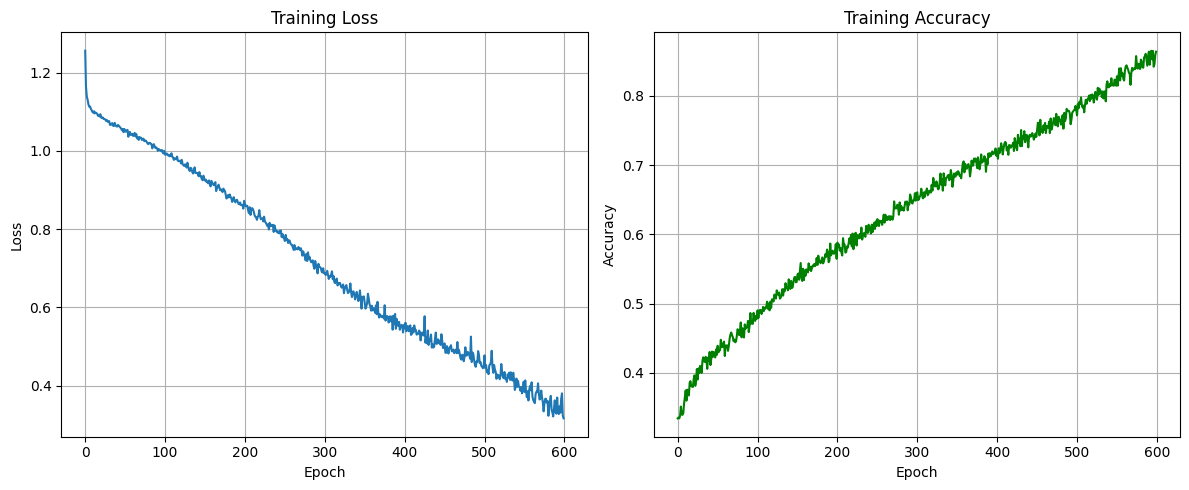

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Flatten images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Initialize updated deep model
model = ImprovedDeepNet(input_size=1024, output_size=3, dropout_rate=0.3)

# Training parameters
epochs = 600
learning_rate = 0.02
batch_size = 64

train_losses, train_accuracies = [], []

for epoch in range(epochs):
    # Shuffle data
    perm = np.random.permutation(X_train_flat.shape[0])
    X_shuffled = X_train_flat[perm]
    y_shuffled = y_train[perm]

    epoch_loss, epoch_correct = 0, 0

    for i in range(0, X_train_flat.shape[0], batch_size):
        X_batch = X_shuffled[i:i+batch_size]
        y_batch = y_shuffled[i:i+batch_size]

        # Forward pass
        y_pred = model.forward(X_batch, training=True)

        # Compute loss
        loss = model.compute_loss(y_batch, y_pred)
        epoch_loss += loss * X_batch.shape[0]

        # Accuracy
        preds = np.argmax(y_pred, axis=1)
        epoch_correct += np.sum(preds == y_batch)

        # Backward pass
        model.backward(y_batch, learning_rate=learning_rate)

    avg_loss = epoch_loss / X_train_flat.shape[0]
    accuracy = epoch_correct / X_train_flat.shape[0]

    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Accuracy', color='green')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()



Test Accuracy: 0.5522

Classification Report:
              precision    recall  f1-score   support

           3       0.50      0.67      0.57       311
           5       0.48      0.35      0.40       295
           7       0.70      0.63      0.66       294

    accuracy                           0.55       900
   macro avg       0.56      0.55      0.55       900
weighted avg       0.56      0.55      0.55       900



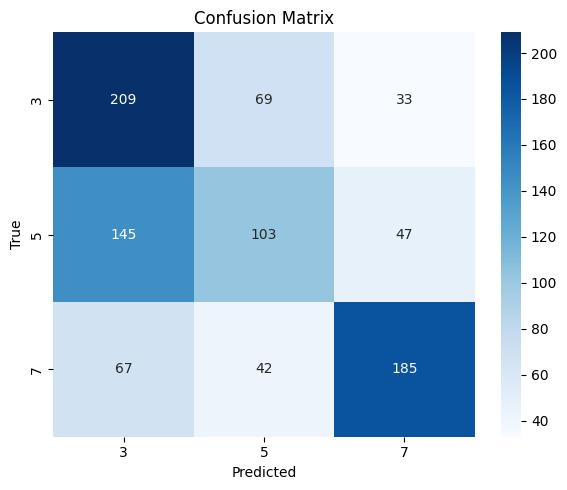

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Flatten test data
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Forward pass on test data (inference mode)
y_test_pred_probs = model.forward(X_test_flat, training=False)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)

# Compute accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
